In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split

In [2]:
import zipfile
import os


zip_path = '/content/train.zip'


extract_path = '/content/dataset'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


print(os.listdir(extract_path))

# Define image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32

['train']


In [3]:
# Create ImageDataGenerator for data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,  # Splitting the data into train/validation sets
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [4]:
from keras.preprocessing.image import ImageDataGenerator


train_data_path = '/content/dataset/train'

# Create an ImageDataGenerator for both training and validation data with a validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Adjust brightness between 0.8 to 1.2
    fill_mode='nearest'
)




train_generator = datagen.flow_from_directory(
    train_data_path,
    target_size=(img_width, img_height),  # Resizes images to 30x30 pixels
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Access class indices and labels generated by flow_from_directory
class_indices = train_generator.class_indices



labels = train_generator.classes


classes = {v: k for k, v in class_indices.items()}


# Map labels to class names
class_names = [classes[label] for label in labels]


# Generate the validation data
validation_generator = datagen.flow_from_directory(
    train_data_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)
print(labels)  # Print the entire array or list of labels
print(labels[3950:4000])
print(class_indices)

Found 3822 images belonging to 10 classes.
Found 1637 images belonging to 10 classes.
[0 0 0 ... 9 9 9]
[]
{'14': 0, '15': 1, '16': 2, '23': 3, '26': 4, '28': 5, '30': 6, '33': 7, '34': 8, '6': 9}


In [5]:
import numpy as np
from collections import Counter


label_counter = Counter(labels)

# Calculate total number of samples
total_samples = len(labels)

# Calculate class weights
class_weights = {}
for label, count in label_counter.items():
    class_weights[label] = total_samples / (len(label_counter) * count)
print(class_weights)

{0: 0.7, 1: 0.8666666666666667, 2: 1.3, 3: 1.0705882352941176, 4: 0.91, 5: 1.011111111111111, 6: 1.2133333333333334, 7: 0.7913043478260869, 8: 1.3, 9: 1.3}


In [6]:
# Load pre-trained VGG16 model without the top classification layer
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the convolutional base
for layer in vgg_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [7]:
#Simple model

from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from keras.regularizers import l2


x = vgg_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=vgg_model.input, outputs=predictions)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model with class weights
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    class_weight=class_weights  # Use class weights during training
)

model.summary()

Epoch 1/15
119/119 [==============================] - 91s 672ms/step - loss: 1.6378 - accuracy: 0.4404 - val_loss: 1.2384 - val_accuracy: 0.5729
Epoch 2/15
119/119 [==============================] - 79s 664ms/step - loss: 1.0628 - accuracy: 0.6100 - val_loss: 1.0129 - val_accuracy: 0.6275
Epoch 3/15
119/119 [==============================] - 79s 665ms/step - loss: 0.8512 - accuracy: 0.6937 - val_loss: 0.9913 - val_accuracy: 0.6066
Epoch 4/15
119/119 [==============================] - 79s 669ms/step - loss: 0.7865 - accuracy: 0.7222 - val_loss: 0.8842 - val_accuracy: 0.6740
Epoch 5/15
119/119 [==============================] - 83s 696ms/step - loss: 0.7231 - accuracy: 0.7420 - val_loss: 0.9384 - val_accuracy: 0.6703
Epoch 6/15
119/119 [==============================] - 83s 696ms/step - loss: 0.6665 - accuracy: 0.7602 - val_loss: 0.8620 - val_accuracy: 0.6820
Epoch 7/15
119/119 [==============================] - 80s 670ms/step - loss: 0.6270 - accuracy: 0.7718 - val_loss: 0.8877 - val_ac

In [15]:
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from keras.regularizers import l2


# Additional layers on top of VGG16
x = vgg_model.output

# Add more convolutional layers
x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = MaxPooling2D((2, 2))(x)

# Flatten layer and Dense layers
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)

# Output layer
predictions = Dense(10, activation='softmax')(x)

# New extended model
model = Model(inputs=vgg_model.input, outputs=predictions)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the extended model with class weights
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    class_weight=class_weights  # Use class weights during training
)

# Display model summary
model.summary()

Epoch 1/15
119/119 [==============================] - 98s 802ms/step - loss: 1.8212 - accuracy: 0.4836 - val_loss: 1.2783 - val_accuracy: 0.6422
Epoch 2/15
119/119 [==============================] - 95s 804ms/step - loss: 0.9618 - accuracy: 0.7694 - val_loss: 1.1255 - val_accuracy: 0.6900
Epoch 3/15
119/119 [==============================] - 81s 675ms/step - loss: 0.7197 - accuracy: 0.8401 - val_loss: 1.2113 - val_accuracy: 0.6801
Epoch 4/15
119/119 [==============================] - 80s 671ms/step - loss: 0.5905 - accuracy: 0.8831 - val_loss: 1.1471 - val_accuracy: 0.6783
Epoch 5/15
119/119 [==============================] - 79s 662ms/step - loss: 0.5440 - accuracy: 0.8894 - val_loss: 1.1772 - val_accuracy: 0.7151
Epoch 6/15
119/119 [==============================] - 84s 702ms/step - loss: 0.4973 - accuracy: 0.9124 - val_loss: 1.0707 - val_accuracy: 0.7224
Epoch 7/15
119/119 [==============================] - 79s 662ms/step - loss: 0.4587 - accuracy: 0.9253 - val_loss: 1.1051 - val_ac

In [8]:
from google.colab import files

# Save the entire model to a HDF5 file
model.save('/content/my_model.h5')

# Download the model file to your local machine
files.download('/content/my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

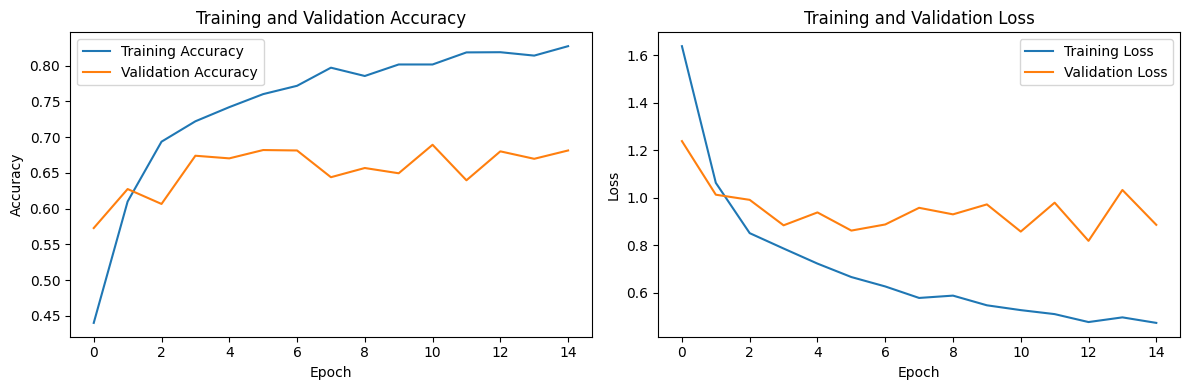

In [9]:
# Plot training history for accuracy and loss
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
import zipfile
import os


zip_path = '/content/Test.zip'


extract_path = '/content/dataset2'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


print(os.listdir(extract_path))

# Define image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32

data_path='/content/dataset2/Test'

['Test']


In [12]:
import pandas as pd
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np


import pandas as pd
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np





from keras.models import load_model
model = load_model('my_model.h5')
model.summary()

{'14': 0, '15': 1, '16': 2, '23': 3, '26': 4, '28': 5, '30': 6, '33': 7, '34': 8, '6': 9}
# Define the category mapping
category_mapping = {
    14: 0,
    15: 1,
    16: 2,
    23: 3,
    26: 4,
    28: 5,
    30: 6,
    33: 7,
    34: 8,
     6: 9
}





test_data = pd.read_csv('/content/Test.csv')


selected_class_ids = [14, 15, 16, 23, 26, 28, 30, 33, 34,6]



filtered_test_data = test_data[test_data['ClassId'].isin(selected_class_ids)]

# Preprocess the images and labels from the filtered DataFrame
test_images = []
test_labels = []

for index, row in filtered_test_data.iterrows():
    img_path = row['Path']
    img = image.load_img(img_path, target_size=(224, 224))  # Resize the image for VGG16
    img = image.img_to_array(img)
    img = preprocess_input(img)  # VGG16-specific preprocessing
    test_images.append(img)

    label = row['ClassId']

    mapped_label = category_mapping[label]
    test_labels.append(mapped_label)  # Append the mapped label

# Convert the lists to NumPy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

from keras.utils import to_categorical



# Convert labels to one-hot encoded format
test_labels = to_categorical(test_labels, num_classes=10)


test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_accuracy}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

55/55 [==============================] - 7s 121ms/step


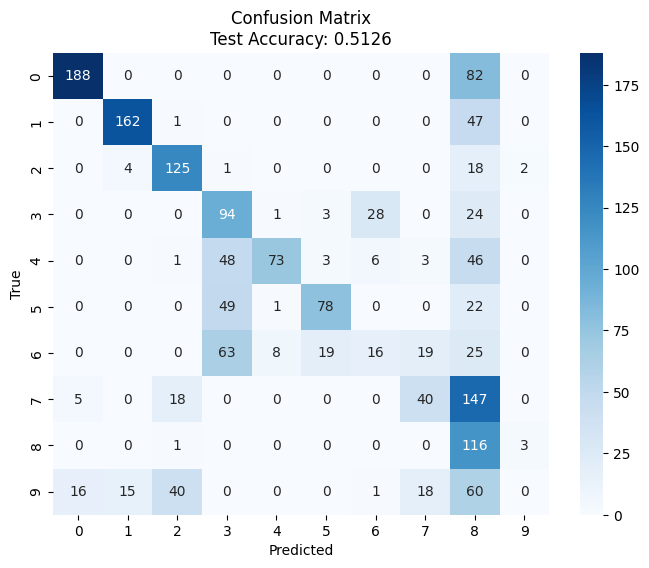

0.5126436781609195


In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Obtain predictions from the model
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_labels)

test_accuracy = np.diag(conf_matrix).sum() / conf_matrix.sum()


# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=category_mapping.values(), yticklabels=category_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix\nTest Accuracy: {test_accuracy:.4f}')
plt.show()
print(test_accuracy)

Min pixel value: -123.68
Max pixel value: 151.061
55/55 [==============================] - 6s 117ms/step
Min pixel value: 0.00658588
Max pixel value: 0.69395745
Min pixel value: 0.00658588
Max pixel value: 0.69395745


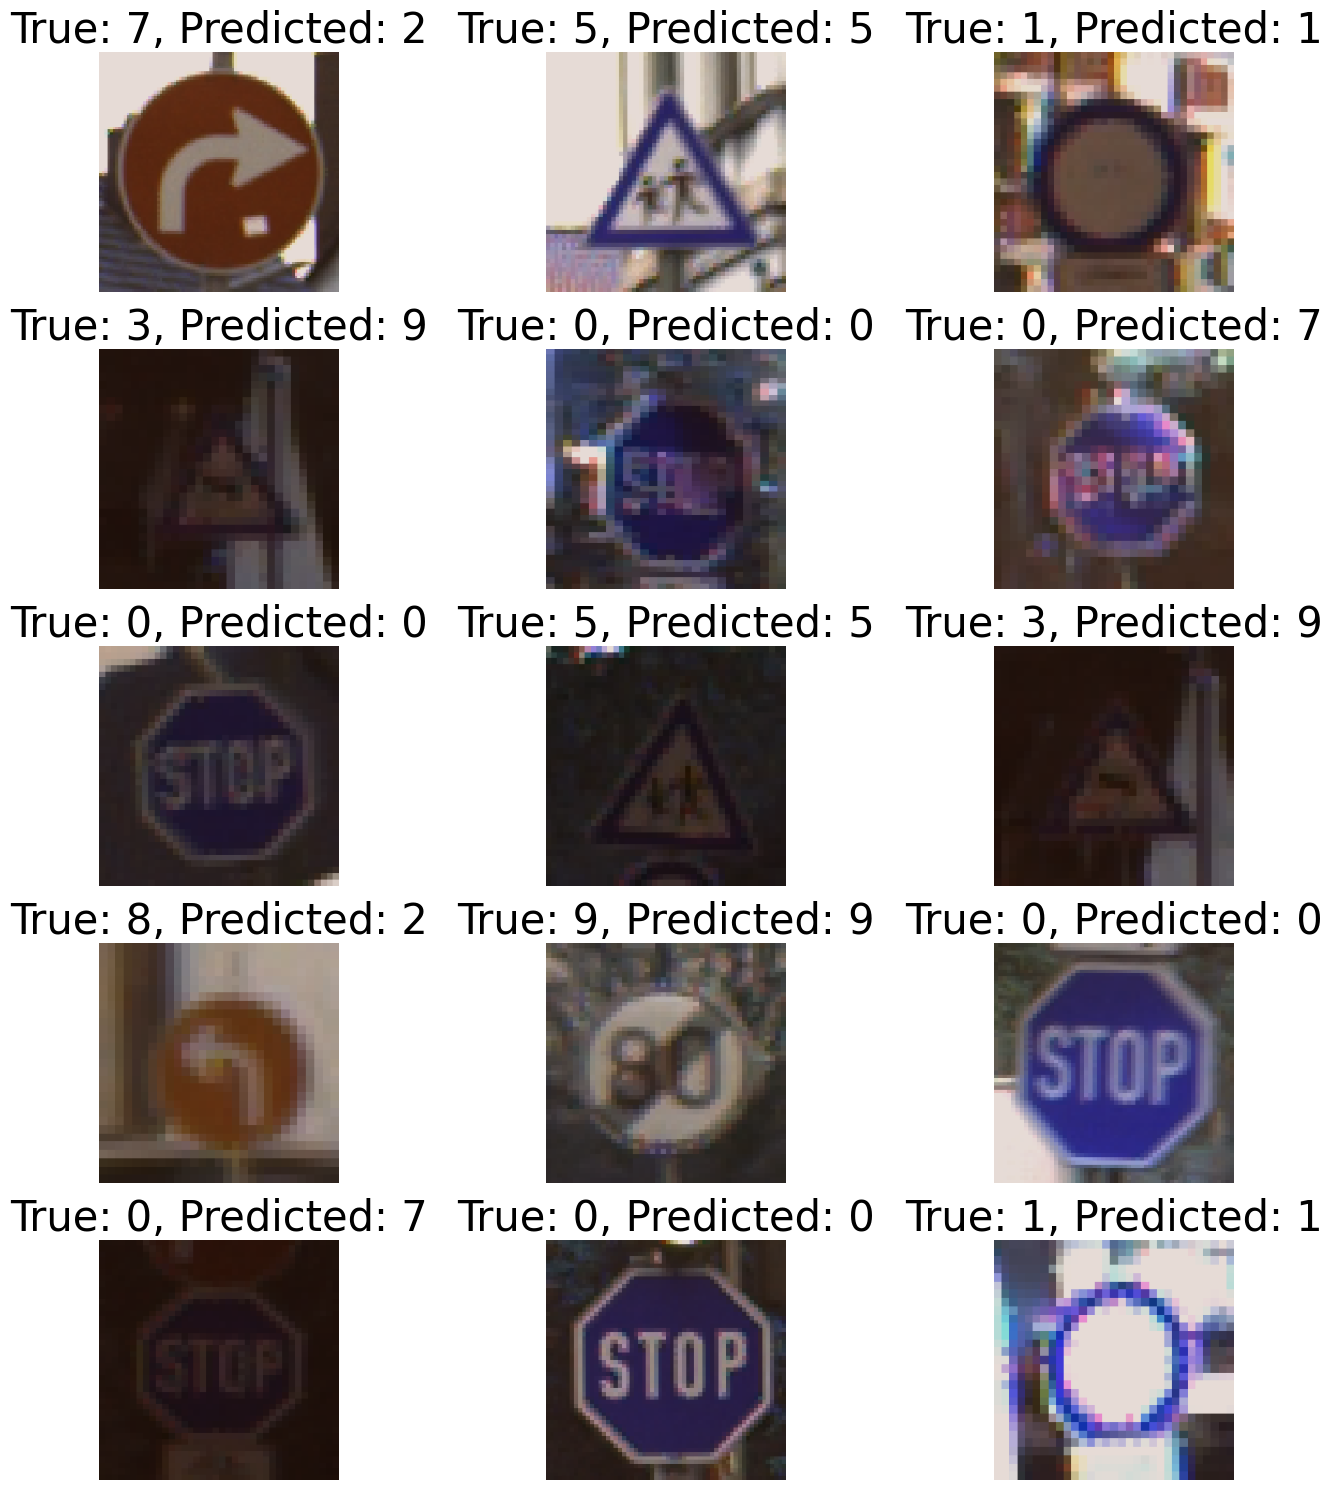

In [14]:
import random
import matplotlib.pyplot as plt
import numpy as np





print("Min pixel value:", np.min(test_images))
print("Max pixel value:", np.max(test_images))


min_value = -123.68
max_value = 180

normalized_test_images = (test_images - min_value) / (max_value - min_value)




# Predict labels for test images
predicted_labels = model.predict(normalized_test_images)
predicted_classes = np.argmax(predicted_labels, axis=1)

sample_image = normalized_test_images[0]  # Choose a sample image

print("Min pixel value:", np.min(sample_image))
print("Max pixel value:", np.max(sample_image))







true_labels = np.argmax(test_labels, axis=1)

sample_image = normalized_test_images[0]
print("Min pixel value:", np.min(sample_image))
print("Max pixel value:", np.max(sample_image))


plt.figure(figsize=(15, 15))

for i in range(1, 16):
    plt.subplot(5, 3, i)
    random_index = random.randint(0, len(normalized_test_images) - 1)
    rand_img = normalized_test_images[random_index]
    plt.imshow(rand_img)

    true_label = true_labels[random_index]
    predicted_label = predicted_classes[random_index]

    plt.title(f'True: {true_label}, Predicted: {predicted_label}', fontsize=30)
    plt.axis('off')

plt.tight_layout()
plt.show()